In [1]:
# prepare the R environment
if (!require("pacman")) install.packages("pacman")
pacman::p_load(
  dplyr,         # Data munging functions
  zoo,              # Feature engineering rolling aggregates
  data.table,       # Feature engineering
  ggplot2,          # Graphics
  scales,           # Time formatted axis
  readr,            # Reading input files
  stringr,          # String functions
  reshape2,         # restructure and aggregate data 
  randomForest,     # Random forests
  corrplot,         # correlation plots
  Metrics,          # Eval metrics for ML
  vcd               # Visualizing discrete distributions
)

# set options for plots
options(repr.plot.width=6, repr.plot.height=6)

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.5.1"Installing package into 'C:/Program Files/R/R-3.5.1/library'
(as 'lib' is unspecified)


package 'corrplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mirela\AppData\Local\Temp\Rtmpmy7TZq\downloaded_packages



corrplot installed
Warning message:
"package 'corrplot' was built under R version 3.4.4"Installing package into 'C:/Program Files/R/R-3.5.1/library'
(as 'lib' is unspecified)


package 'Metrics' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mirela\AppData\Local\Temp\Rtmpmy7TZq\downloaded_packages



Metrics installed
Warning message:
"package 'Metrics' was built under R version 3.4.4"Installing package into 'C:/Program Files/R/R-3.5.1/library'
(as 'lib' is unspecified)
also installing the dependency 'lmtest'



package 'lmtest' successfully unpacked and MD5 sums checked
package 'vcd' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mirela\AppData\Local\Temp\Rtmpmy7TZq\downloaded_packages



vcd installed
Warning message:
"package 'vcd' was built under R version 3.4.4"

In [1]:
# Load the data
googFile <-"C:\\Users\\Mirela\\RStudioProjects\\Regression_file\\Regression_Data\\goog.csv"
nasdaqFile<-"C:\\Users\\Mirela\\RStudioProjects\\Regression_file\\Regression_Data\\Nasdaq.csv"
tbondsFile <-"C:\\Users\\Mirela\\RStudioProjects\\Regression_file\\Regression_Data\\tbond8yr.csv"
if(!file.exists(googFile)){tryCatch(googFile)}

if(file.exists(googFile)) goog_original <- read.csv(googFile)

head(goog_original)

Date,Open,High,Low,Close,Adj.Close,Volume
01/10/2010,263.2876,310.3515,257.7486,304.8671,304.8671,159726000
01/11/2010,305.8756,313.3867,274.8672,276.0595,276.0595,117642000
01/12/2010,279.6809,301.5388,279.3829,295.0659,295.0659,85118500
01/01/2011,296.3128,319.4026,295.8508,298.2402,298.2402,120747200
01/02/2011,300.2919,313.5507,298.7320,304.7181,304.7181,84280400
01/03/2011,306.8940,307.6093,273.8588,291.4842,291.4842,121057900


In [2]:

# eliminate any duplicates that may exist in the dataset

googs <- goog_original%>%
  distinct(.keep_all = TRUE,Date,Volume,Adj.Close)

# the date field is formatted as a string - transform that into R date
googs$Date<-as.POSIXct(strptime(googs$Date,"%d/%m/%Y",tz="UTC"))

# generate an id column for future use (joins etc)
googs$goog_id = seq.int(nrow(googs))

head(googs)
summary(googs)

ERROR: Error in goog_original %>% distinct(.keep_all = TRUE, Date, Volume, Adj.Close): could not find function "%>%"


In [3]:
# how many volumes have been realized over the years?
googs %>% 
  ggplot(mapping = aes(year(Date))) +
  geom_bar(aes(fill= Volume), width=1, color="black") +
  theme(legend.position = "bottom", legend.direction = "vertical") + ggtitle("Volumes by Year")

ERROR: Error in googs %>% ggplot(mapping = aes(year(Date))): could not find function "%>%"


In [4]:
# what values is our dataset missing?

ggplot_missing <- function(x){
  
  x %>%
    is.na %>%
    melt %>%
    ggplot(mapping = aes(x = Var2,
                         y = Var1)) +
    geom_raster(aes(fill = value)) +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme(axis.text.x  = element_text(angle=45, vjust=0.5)) +
    labs(x = "Variables in Dataset",
         y = "Rows / observations")
}

ggplot_missing(googs)

ERROR: Error in x %>% is.na %>% melt %>% ggplot(mapping = aes(x = Var2, y = Var1)): could not find function "%>%"


In [5]:
# Preprocessing the data

googTable <-read.table(googFile,header = TRUE, sep ="," )[,c("Date","Adj.Close")]
nasdaqTable <- read.table(nasdaqFile,header = TRUE, sep = ",")[,c("Date","Adj.Close")]
tbondsTable <- read.table(tbondsFile, header = TRUE, sep = ",")[,c("Date","Adj.Close")]
names(tbondsTable)[2] <- "tbonds.outcomes"
tbondsTable[,c("Date")]<- as.Date(tbondsTable[,c("Date")])
googTable <- merge(googTable,nasdaqTable, by="Date")
googTable[,c("Date")]<- as.Date(googTable[,c("Date")])
googTable <- googTable[order(googTable$Date,decreasing = TRUE),]
names(googTable)[2:3] <- c("goog.prices","nasdaq.prices")
googTable[-nrow(googTable),-1] <- googTable[-nrow(googTable),-1]/googTable[-1,-1]-1
googTable<-googTable[-nrow(googTable),]
names(googTable)[2:3] <- c("goog.outcomes","nasdaq.outcomes")
googTable<-merge(googTable,tbondsTable,by="Date")
googTable$tbonds.outcomes<-googTable$tbonds.outcomes/100
googTable[,c("goog.outcomes","nasdaq.outcomes")] <- googTable[,c("goog.outcomes","nasdaq.outcomes")]-googTable[,"tbonds.outcomes"]

#Build a linear model that accounts for missing values

googM<- lm(googTable$goog.outcomes~googTable$nasdaq.outcomes, na.action = na.omit)
# Deal with missing values in the preprocessing step itself

googTable[,"goog.outcomes"][is.na(googTable[,"goog.outcomes"])]<-mean(googTable[,"goog.outcomes"])

In [6]:
#Including a categorical variable

googTable$Month = format(googTable$Date,"%m")
dummyVars <- model.matrix(~Month,googTable)
goog_MLR <- lm(googTable$goog.outcomes~googTable$nasdaq.outcomes+googTable$Month)
summary(goog_MLR)


Call:
lm(formula = googTable$goog.outcomes ~ googTable$nasdaq.outcomes + 
    googTable$Month)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49032 -0.11124  0.01695  0.08732  0.80049 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                0.061766   0.024895   2.481  0.01332 *  
googTable$nasdaq.outcomes  1.637774   0.011223 145.927  < 2e-16 ***
googTable$Month02         -0.024176   0.034118  -0.709  0.47879    
googTable$Month03         -0.033108   0.034101  -0.971  0.33193    
googTable$Month04         -0.035605   0.034105  -1.044  0.29682    
googTable$Month05          0.024748   0.034105   0.726  0.46828    
googTable$Month06          0.041322   0.034107   1.212  0.22608    
googTable$Month07          0.102421   0.034116   3.002  0.00277 ** 
googTable$Month08         -0.022600   0.034125  -0.662  0.50800    
googTable$Month09         -0.005845   0.034135  -0.171  0.86409    
googTable$Month10          0.004968  

Loading required package: MASS
Warning message:
"package 'MASS' was built under R version 3.5.1"

ERROR: Error in rlm(googTable$goog.outcomes ~ googTable$nasdaq.outcomes): could not find function "rlm"


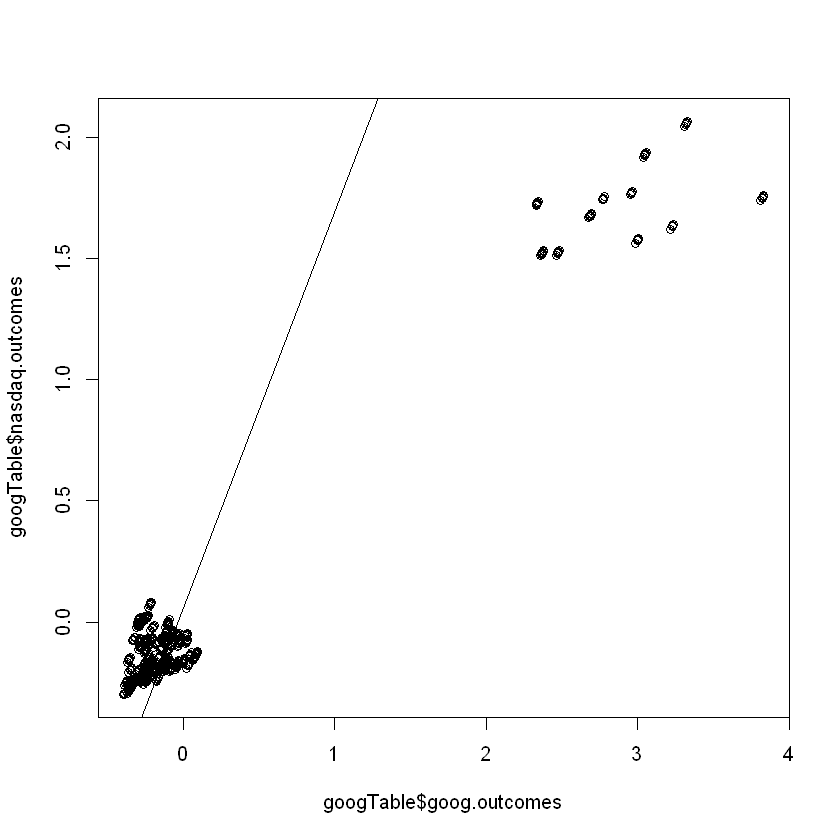

In [7]:
#Robust linear regression 

plot(googTable$goog.outcomes,googTable$nasdaq.outcomes)
abline(googM)
require(MASS)
googRLM<- rlm(googTable$goog.outcomes~googTable$nasdaq.outcomes)
abline(googRLM,lty ="twodash")

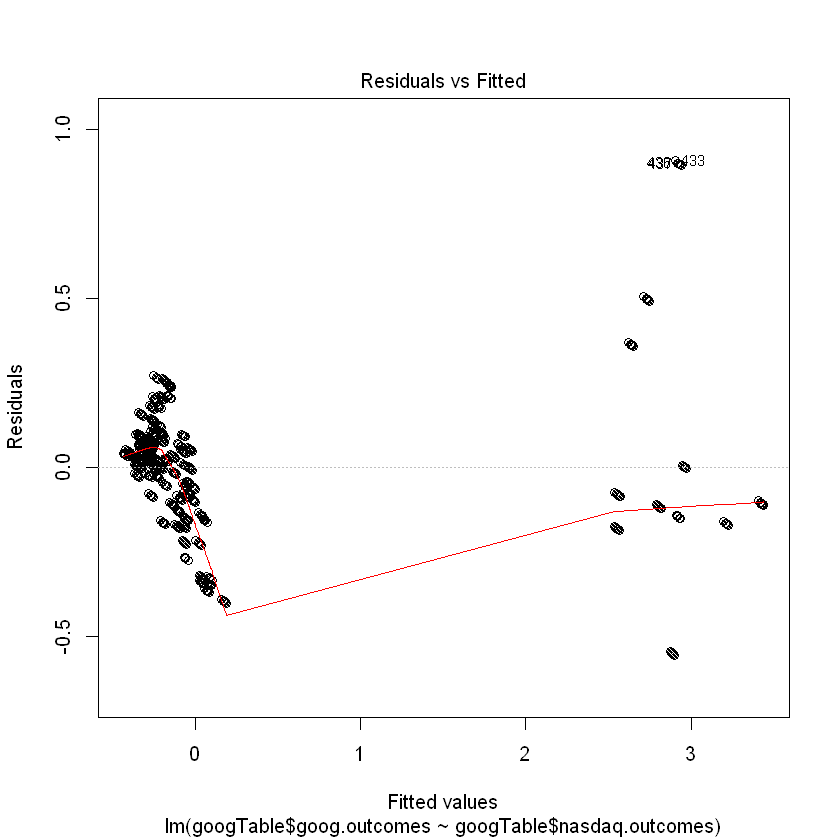

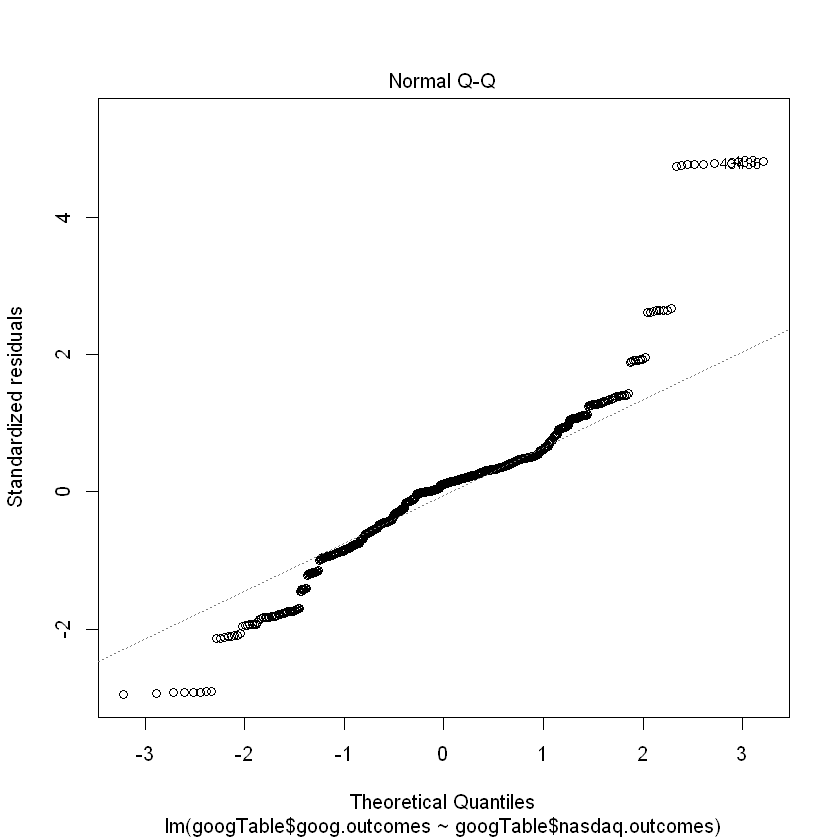

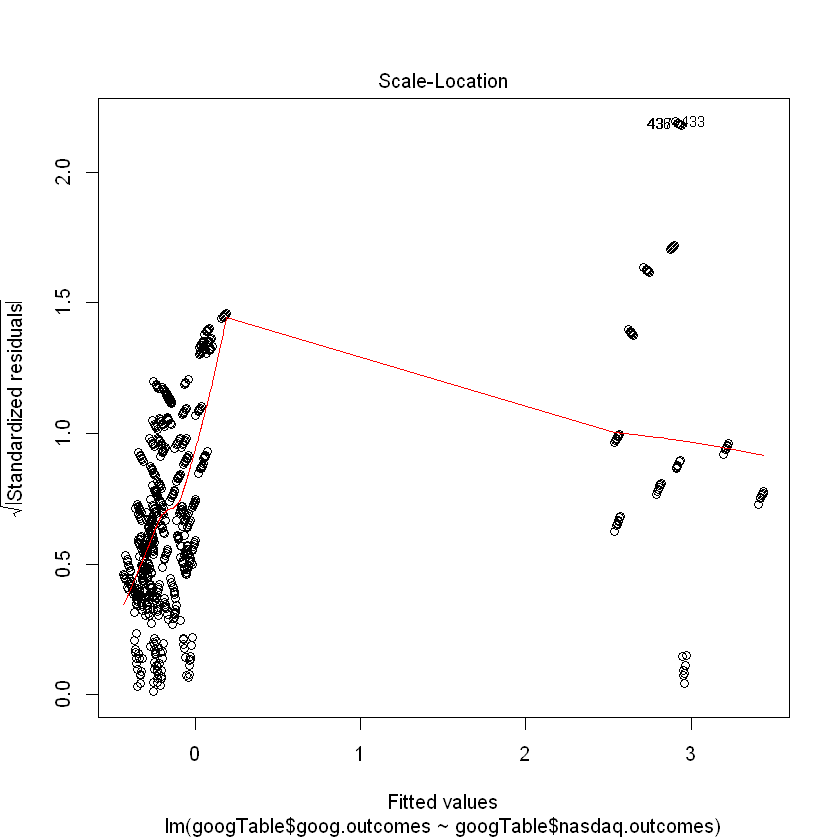

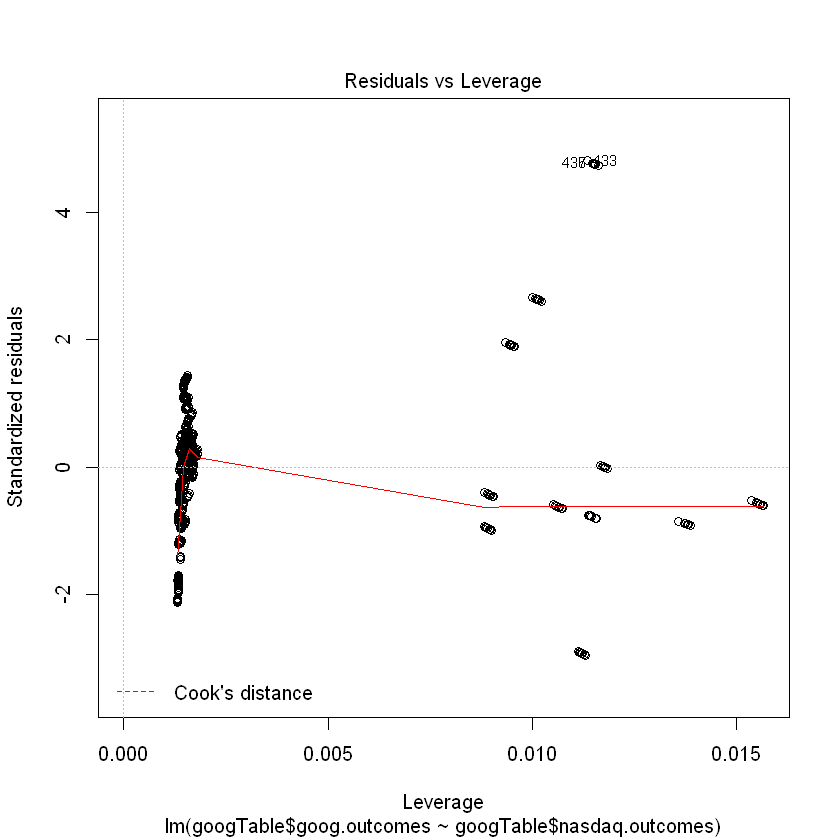

In [8]:
#Diagnostic plots 
plot(googM) 